In [1]:
import numpy as np
import splat
import wisps
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import wisps.simulations as wispsim

In [3]:
import wisps.simulations.compute_distances as comp

hst3d


In [4]:
from astropy.coordinates import SkyCoord

In [5]:
J1_NIPS=24 #limiting mag in NISP
J2_NIPS=27 #best case scenario

In [6]:
def get_abs_mag(spt):
    #magnitude from spt and relation
    j, h=wisps.absolute_magnitude_jh(spt)
    return j

In [7]:
spgrid=np.arange(17, 38)

In [8]:
abs_mags=np.array([get_abs_mag(s ) for s in spgrid])

In [9]:
dmaxs1=wispsim.get_distance(abs_mags, np.ones_like(abs_mags)*J1_NIPS)
dmaxs2=wispsim.get_distance(abs_mags, np.ones_like(abs_mags)*J2_NIPS)

In [10]:
import astropy.units as u

In [11]:
EDFS=SkyCoord(l=24.6*u.deg, b=-82.0*u.deg , frame='galactic').galactic
EDF_CH=SkyCoord("3:32:28.0 -27:48:30" , obstime="J2000", unit=u.deg).galactic

In [12]:
#compute volume correction terms 
EDFS_vcs1=np.array([ wispsim.custom_volume(EDFS.l.radian,EDFS.b.radian, 1., dm, 350.) for dm in dmaxs1])
EDF_CH_vcs1=np.array([ wispsim.custom_volume(EDF_CH.l.radian, EDFS.b.radian,1, dm, 350.) for dm in dmaxs1])

EDFS_vcs2=np.array([ wispsim.custom_volume(EDFS.l.radian,EDFS.b.radian, 1., dm, 350.) for dm in dmaxs2])
EDF_CH_vcs2=np.array([ wispsim.custom_volume(EDF_CH.l.radian, EDFS.b.radian,1, dm,  350.) for dm in dmaxs2])

In [13]:
EDFS_CH_vols1=EDF_CH_vcs1*(20*(u.deg**2)).to(u.radian**2)
EDF_vols1=EDFS_vcs1*(10*(u.deg**2)).to(u.radian**2)

EDFS_CH_vols2=EDF_CH_vcs2*(20*(u.deg**2)).to(u.radian**2)
EDF_vols2=EDFS_vcs2*(10*(u.deg**2)).to(u.radian**2)

In [14]:
LF=pd.read_pickle(wisps.OUTPUT_FILES+'/lf.pkl')

In [15]:
from scipy.interpolate import interp1d

In [16]:
lf=interp1d(LF['spt'], LF['phi'])

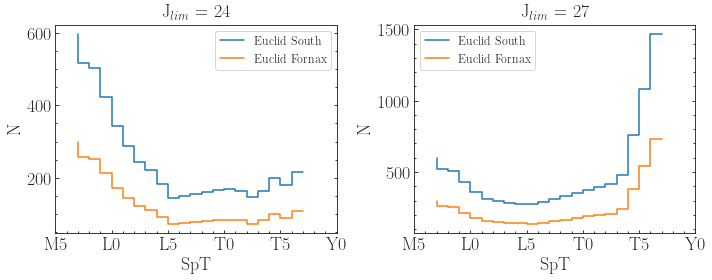

In [17]:
fig, (ax, ax1)=plt.subplots(ncols=2, figsize=(10, 4), sharey=False, sharex=True)
ax.step(spgrid, lf(spgrid)*EDFS_CH_vols1, label='Euclid South')
ax.step(spgrid, lf(spgrid)*EDF_vols1, label='Euclid Fornax')

ax1.step(spgrid, lf(spgrid)*EDFS_CH_vols2, label='Euclid South')
ax1.step(spgrid, lf(spgrid)*EDF_vols2, label='Euclid Fornax')

ax.set_title(r'J$_{lim}$ = 24', fontsize=18)
ax1.set_title(r'J$_{lim}$ = 27', fontsize=18)

for a in [ax, ax1]:
    a.minorticks_on()
    a.set_xlabel('SpT', fontsize=18)
    a.legend()
    #a.set_yscale('log')
    a.set_ylabel(r'N', fontsize=18)
    a.set_xticks([15, 20, 25, 30, 35, 40])
    a.set_xticklabels(['M5', 'L0', 'L5', 'T0', 'T5', 'Y0'])




plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/euclid_predictions.pdf')